OLS(Ordinary Least Square) 방법을 사용하면 데이터에 대한 확률론적인 가정이 없어도 최적의 가중치를 계산할 수 있었다. 그러나 계산한 가중치가 어느 정도의 신뢰도를 가지는지 확인할 수 있는 방법이 없다.

예를 들어 보스턴 집값의 선형 회귀모형에서 OLS로 계산한 범죄율에 대한 가중치는 약  −0.1080 이었다. 만약 이 값이 정확한 값이라면 집값은 범죄율에 반비례한다는 결론을 내릴 수 있다. 하지만  −0.1080 은 표본에서 계산된 추정치일 뿐이며 추정 오차가 있을 수 있다. 

만약 추정 오차의 크기가  0.0001  수준이라면 실제 가중치는  −0.1080±0.0001  즉,  −0.1081∼−0.1079  정도이고 집값이 범죄율에 반비례한다는 결론은 바뀌지 않을 것이다. 하지만 만약 추정 오차의 크기가  0.2  수준이라면 실제 가중치는  −0.3081∼0.0920  정도의 범위가 된다. 다시 말해 진짜 가중치는 0이 될 수도 있고 양수가 될 수 있다. 만약 가중치가 0이라면 범죄율과 집값은 아무런 상관 관계가 없다는 결론이 나온다. 만약 가중치가 양수이면 집값은 범죄율에 정비례한다는 결론이 나올 수도 있다. 즉 가중치의 오차 범위 혹은 신뢰 구간을 계산할 수 없다면 OLS 결과로부터 실질적인 결론을 이끌어내기 어렵다.

## 부트스트래핑

##### 부트스트래핑(bootstrapping)은 회귀분석에 사용한 표본 데이터가 달라질 때 회귀분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법이다.

OLS로 구한 가중치의 추정값은 표본 데이터에 따라 달라진다. 만약 여러가지 다른 표본 데이터 집합이 있다면 이 데이터들을 넣어보면서 가중치가 어느 정도 달라지는지에 대한 감을 얻을 수 있을 것이다. 그러나 현실적으로는 추가적인 데이터를 얻기 어렵기 때문에 부트스트래핑 방법에서는 기존의 데이터를 재표본화(re-sampling)하여 여러가지 다양한 표본 데이터 집합을 만드는 방법을 사용한다. 재표본화는 기존의  𝑁 개의 데이터에서 다시  𝑁 개의 데이터를 선택하되 중복 선택도 가능하게 한다(unordered resampling with replacement).

직접 부트스트래핑을 실시해 보자. 다음과 같은 선형 회귀 모형을 따르는 100개의 가상 데이터를 생성한다. 모형에 사용된 모수는 상수항이  𝑤0=0 , 기울기가  𝑤1=42.3855 이다.

$$y = w_0 + w_1 x + \epsilon$$

In [1]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=0)
coef

array(42.38550486)

이 표본 데이터를 기반으로 회귀분석을 실시한다.

In [3]:
import pandas as pd
import statsmodels.api as sm

dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

추정된 가중치값은 params 속성에 저장되어 있다. 상수항의 추정치가  𝑤̂ 0=−1.628364 , 기울기의 추정치가  𝑤̂ 1=42.853356 로 실제 모수와 다르다는 것을 알 수 있다.

In [4]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

다음으로 이 데이터를 재표본화하여 다른 데이터 집합을 만들고 이 데이터를 기반으로 다시 회귀분석을 한다. 여기에서는 이러한 회귀분석을 1,000번 반복한다. 그 결과로써 1,000개의 다른 가중치 추정값이 나오게 된다.

In [5]:
import numpy as np

In [6]:
%%time
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)

for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

CPU times: user 5.24 s, sys: 145 ms, total: 5.39 s
Wall time: 3.21 s


전체 가중치 추정값 집합을 히스토그램으로 나타내면 다음과 같다.

In [7]:
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=12).get_name()

plt.rc('font', family=font_name)

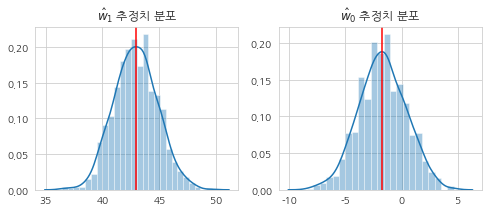

In [8]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")

plt.show()

추정치 분포의 평균과 분산은 다음과 같다. 기울기의 추정치 분포는 평균이  42.92 , 표준편차가  1.92 이다. 대부분의 데이터가  42.92±3.84  ( 𝑥¯±2𝑠 ) 사이에 있다. 따라서 오차가 큰 경우에도 0 혹은 음수가 될 가능성은 적다.

In [9]:
params_w1.mean(), params_w1.std()

(42.91868415110692, 1.9034056787413076)

그런데 상수항의 추정치 분포는 평균이  −1.65 , 표준편차가  2.13 이다. 대부분의 데이터가  −1.67±4.26(−5.99∼2.65)  사이에 있기 때문에 0일 수도 있고 혹은 음수일 수도 있다.

In [10]:
params_w0.mean(), params_w0.std()

(-1.696242172546713, 2.1064696237923126)

이 결과를 statsmodels의 summary 메서드로 출력한 보고서와 비교해보면 추정치의 표준편차와 비슷한 값이 std err이라는 이름으로 표시되어 있고  𝑥¯±2𝑠 로 추정한 구간과 비슷한 값이 [0.025 0.975] 열 아래에 표시되어 있다. 예를 들어 상수항 추정치는 std err가 2.163 이고 [0.025 0.975]열 값이  −5.920∼2.663 이다.

In [11]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Wed, 14 Aug 2019   Prob (F-statistic):           2.21e-36
Time:                        07:12:31   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

하지만 이 보고서의 값은 부트스트래핑을 사용하여 구한 값이 아니라 확률론적 선형 회귀모형을 사용한 것이다. 
##### 확률론적 선형 회귀모형을 쓰면 부트스트래핑처럼 많은 계산을 하지 않아도 빠르고 안정적으로 가중치 추정값의 오차를 구할 수 있다.

## 확률론적 선형 회귀모형

확률론적 선형 회귀모형에서는 데이터가 확률 변수로부터 생성된 표본이라고 가정한다. 구체적인 가정은 다음과 같다.

(1) 선형 정규 분포 가정

##### 선형 회귀분석의 기본 가정은 종속 변수  𝑦 가 독립 변수  𝑥 의 선형 조합으로 결정되는 기댓값과 고정된 분산  𝜎2 을 가지는 가우시안 정규 분포라는 것이다.

$$y \sim \mathcal{N}(w^Tx, \sigma^2)$$

y의 확률 밀도 함수는 다음처럼 쓸 수 있다. 이 식에서 모수 벡터  𝜃=(𝑤,𝜎2) 이다.

$$p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 )$$

이 관계식을 잡음(disturbance)  𝜖  개념으로 변환하면 더 간단하게 표현할 수 있다.

$$\epsilon = y - w^Tx$$

$$p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 )$$

여기에서 주의할 점은

#### x, y 중 그 어느 것도 그 자체로 정규 분포일 필요는 없다

는 것이다.

𝑦 도  𝑥 에 대해 조건부로 정규 분포를 이루는 것이지  𝑦  자체가 무조건부로 정규분포는 아니다.

(2) 외생성(Exogeneity) 가정

##### 잡음  𝜖 의 기댓값은 독립 변수  𝑥 의 크기에 상관없이 항상 0이라고 가정한다. 이를 외생성(Exogeneity) 가정이라고 한다.

$$\text{E}[\epsilon \mid x] = 0$$

외생성 가정으로부터와 잡음  𝜖 의 무조건부 기댓값이 0임을 증명할 수 있다.

$$\text{E}[\epsilon] = \text{E}[\text{E}[\epsilon \mid x]] = 0$$

역은 성립하지 않는다. 즉 조건부 기댓값이 0이면 기댓값은 0이지만 기댓값이 0이라고 조건부 기댓값이 0이 되지는 않는다.

그리고 같은 가정으로부터 잡음  𝜖 와 독립 변수  𝑥 가 상관 관계가 없다는 것도 증명할 수 있다.

$$\text{E}[\epsilon x] = \text{E}[\text{E}[\epsilon x \mid x]] = \text{E}[x \text{E}[\epsilon\mid x]] = 0$$

(3) 조건부 독립 가정

##### 𝑖 번째 표본의 잡음  𝜖𝑖 와  𝑗 번째 표본의 잡음  𝜖𝑗 의 공분산 값이  𝑥 와 상관없이 항상 0이라고 가정한다.

$$\text{Cov}[\epsilon_i, \epsilon_j \mid x] = 0 \;\; (i,j=1,2,\ldots,N)$$

이는  𝑖 번째 표본의 잡음  𝜖𝑖 와  𝑗 번째 표본의 잡음  𝜖𝑗 는 서로 독립이라는 가정과 같다.

이 가정과 위의 다른 가정들로부터 다음을 증명할 수 있다.

$$\text{E}[\epsilon_i \epsilon_j] = 0 \;\; (i,j=1,2,\ldots,N)$$

잡음 벡터  𝜖 의 공분산 행렬이 대각행렬이 되어야 한다는 조건과 같다. (비대각 성분이 모두 0이어야 한다.)

$$\text{Cov}[\epsilon] = \text{E}[\epsilon^{} \epsilon^T] = \text{diagonal matrix}$$

(4) 등분산성 가정

##### 𝑖 번째 표본의 잡음  𝜖𝑖 와  𝑗 번째 표본의 잡음  𝜖𝑗 의 분산 값이 표본과 상관없이 항상 같다고 가정한다.

잡음 벡터  𝜖 의 공분산 행렬이 항등행렬 형태가 되어야 한다는 조건과 같다.

$$\text{Cov}[\epsilon] = \text{E}[\epsilon^{} \epsilon^T] = \sigma^2I$$

## 최대 가능도 방법을 사용한 선형 회귀분석

확률론적 선형 회귀모형의 가정과 최대 가능도 방법(Maximum Likelihood Estimation)을 사용하여 가중치 벡터  𝑤 의 값을 구해보자.

가능도는 다음과 같다.

\begin{eqnarray}
p(y_{1:N} \,\big|\, x_{1:N}, \theta)
&=& \prod_{i=1}^N \mathcal{N}(y_i \,\big|\, w^T x_i , \sigma^2) \\
&=& \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
\end{eqnarray}

계산을 쉽게하기 위해 Log를 적용하여 로그 가능도(log-likelihood)를 구한다.

\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 - \dfrac{N}{2} \log{2\pi}{\sigma^2}  \\
\end{eqnarray}

이를 행렬로 표시하면 다음과 같다.

$$\text{LL}  =  -C_1 (y - Xw)^T(y-Xw) - C_0 = -C_1(w^TX^TXw -2 y^TXw + y^Ty) - C_0$$

$$C_1 =  -\dfrac{1}{2\sigma^2}$$

$$C_0 =  \dfrac{N}{2} \log{2\pi}{\sigma^2}$$

최적화하면 OLS와 동일한 결과를 얻을 수 있다.

$$\dfrac{d}{dw} \text{LL} = -C_1 \left( 2X^TX \hat{w} - 2X^Ty \right) = 0$$

$$\hat{w} = (X^TX)^{-1}X^T y$$

최대 가능도 방법에서도 OLS의 직교 방정식과 같은 직교 방정식을 얻을 수 있다.

$$X^TX \hat{w} - X^Ty = 0$$

$$X^T(X \hat{w} - y) = X^T(\hat{y} - y) = X^Te = 0$$

## 잔차의 분포

###### 확률론적 선형 회귀모형에 따르면 회귀분석에서 생기는 잔차  𝑒=𝑦−𝑤̂ 𝑇𝑥  도 정규 분포를 따른다. 

다음과 같이 증명할 수 있다.

확률론적 선형 회귀모형의 잡음  𝜖 와 잔차  𝑒 는 다음과 같은 관계를 가진다.

$$\hat{y} = X\hat{w} = X (X^TX)^{-1}X^T y = Hy$$

이 행렬  𝐻 은 Hat 행렬 혹은 프로젝션(projection) 행렬 또는 영향도(influence) 행렬이라고 부르는 대칭 행렬이다.

Hat 행렬을 이용하면 잔차는 다음처럼 표현된다.

$$e = y - \hat{y}= y - Hy = (I - H) y = My$$

이 행렬  𝑀 은 잔차(residual) 행렬이라고 부른다.

확률적 선형 회귀 모형의 가정을 적용하면,

$$e = My = M (Xw + \epsilon) = MXw + M\epsilon$$

즉, 잔차  𝑒 는 잡음  𝜖 의 선형 변환(linear transform)이다. 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 다른다.

In [12]:
import scipy as sp
import scipy.stats

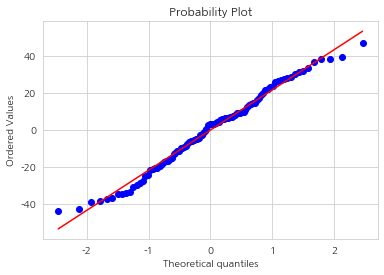

In [13]:
sp.stats.probplot(result.resid, plot=plt) # Q-Q plot
plt.show()

잔차의 정규성은 다음과 같이 정규성 검정을 통해 살펴볼 수도 있다.

In [14]:
test = sm.stats.omni_normtest(result.resid)
test

NormaltestResult(statistic=3.5225056601675333, pvalue=0.17182945580489326)

In [15]:
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [16]:
test = sm.stats.jarque_bera(result.resid)
test

(2.0585394799860923,
 0.35726776369010976,
 -0.07259247821264342,
 2.3122712717761096)

In [17]:
for xi in zip(["Jarque-Bera", 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


또한 오차의 기댓값이  𝑥 와 상관없이 0이므로 잔차의 기댓값도  𝑥 와 상관없이 0이어야 한다.

$$E[𝑒|𝑥]=0$$
 
다음은  𝑥 값이 달라짐에 따라 잔차의 분포가 어떻게 바뀌는 지를 살펴보기 위한 것이다.  𝑥 값이 달라져도 분포의 형태가 크게 바뀌지 않음을 알 수 있다.

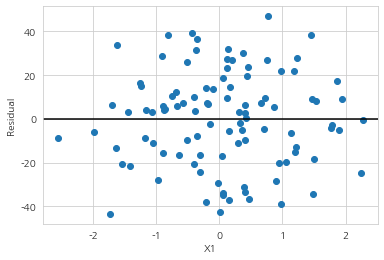

In [20]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

다음은  𝑥 가  𝑒 에 미치는 영향을 살피기 위해  0<𝑥<1 인 구간과  1<𝑥<2 인 구간으로 나누어  𝑒  분포의 모양을 살펴본 것이다. 둘 다 기댓값이 0에 가깝고 분산의 크기가 비슷함을 알 수 있다.

In [21]:
X0.shape

(100, 1)

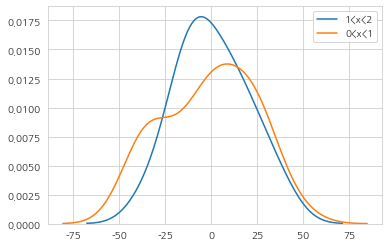

In [22]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1<x<2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0<x<1")
plt.legend()
plt.show()

In [26]:
result.resid[((1 < X0) & (X0 < 2)).flatten()].mean(), result.resid[((1 < X0) & (X0 < 2)).flatten()].std()

(0.8315840246840316, 19.37836265474579)

In [27]:
result.resid[((0 < X0) & (X0 < 1)).flatten()].mean(), result.resid[((0 < X0) & (X0 < 1)).flatten()].std()

(-0.9383616315036388, 24.436125593248548)

## 회귀 계수의 표준 오차

가중치의 예측치  𝑤̂   도 정규 분포 확률 변수인  𝜖 의 선형 변환이므로 정규 분포를 따른다.

\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\
&=& w + (X^TX)^{-1} X^T \epsilon \\
\end{eqnarray}

𝑤̂  의 기댓값은 다음과 같다.

\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w + (X^TX)^{-1} X^T \epsilon ] \\
&=&  w + (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\
&=& w
\end{eqnarray}

따라서  𝑤̂  는  𝑤 의 비편향 추정값(unbiased estimate)이다.

𝑤̂  의 공분산은 다음과 같다.

\begin{eqnarray}
\text{Cov}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}

그런데 잡음의 분산 E[𝜖2]=𝜎2의 값은 알지 못하므로 다음과 같이 잔차의 분산 E[𝑒2]으로부터 추정한다.

\begin{eqnarray}
\text{E}[e^2] 
&=& \text{E}[(M\epsilon)^2] \\
&=& \text{E}[(\epsilon^T M^T)(M\epsilon)] \\
&=& \text{E}[ \epsilon^T M \epsilon] \\
&=& \text{E}[ \text{tr}(\epsilon^T M \epsilon) ] \\
&=& \text{tr}( \text{E}[ M \epsilon \epsilon^T ]) \\
&=& \text{tr}( M \text{E}[\epsilon \epsilon^T ]) \\
&=& \text{tr}( M \sigma^2 I ) \\
&=& \sigma^2 \text{tr}(M) \\
&=& \sigma^2 \text{tr}(I - X(X^TX)^{-1}X^T) \\
&=& \sigma^2 \left( \text{tr}(I) - \text{tr}((X^TX)^{-1}(X^TX))  \right) \\
&=& \sigma^2 (N-K) \\
\end{eqnarray}

여기에서  𝑁 은 표본 데이터의 수,  𝐾 는  𝑋  행렬의 열의 수 즉, 모수의 갯수이다. 상수항을 포함한 선형 모형이라면 모수의 갯수는 입력 데이터의 차원의 수  𝐷 에 1을 더한 값이 된다.

$$K = D + 1$$

따라서 잡음에 대한 비편향 표본분산은 다음과 같다.

$$s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K}$$

𝑤̂  의 (공)분산의 추정값은 다음과 같다.

$$\text{Cov}[\hat{w}] \approx s^2(X^TX)^{-1}$$

이 공분산 행렬에서 우리가 관심을 가지는 값은  𝑤𝑖 의 분산을 뜻하는 대각 성분이다.

$$\text{Var}[\hat{w}_i]  = \left( \text{Cov}[\hat{w}] \right)_{ii} \;\; (i=0, \ldots, K-1)$$

##### 이 값에서 구한 표준 편차를 회귀 계수의 표준 오차(Standard Error of Regression Coefficient)라고 한다.

$$\sqrt{\text{Var}[\hat{w}_i]} \approx {se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} \;\; (i=0, \ldots, K-1)$$

실제 가중치 계수  𝑤𝑖 와 우리가 추정한 가중치 계수  𝑤̂ 𝑖 의 차이를 표준 오차를 나눈 값, 즉 정규화된 모수 오차는 자유도가  𝑁−𝐾 인 표준 스튜던트 t 분포를 따른다.

$$\dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} \;\; (i=0, \ldots, K-1)$$

## 단일 계수 t-검정 (Single Coefficient t-test)

정규화된 모수 오차  𝑤̂𝑖 / 𝑠𝑒𝑖 를 검정 통계량으로 사용하면  𝑤𝑖 가 0 인지 아닌지에 대한 검정을 실시할 수 있다.

$$H_0 : \;\; w_i = 0 \;\; (i=0, \ldots, K-1)$$
 
만약 이 검정에 대한 유의 확률이 0에 가깝게 나온다면 위의 귀무가설은 기각이므로  𝑤𝑖  값이 0일 가능성은 적다. 하지만 유의 확률이 유의 수준을 넘는 큰 값이 나온다면 반대로  𝑤𝑖  값이 0일 가능성이 크다. 즉, 해당 독립 변수는 종속 변수와 아무런 상관성이 없을 가능성이 있다는 뜻이다.

StatsModels summary 메서드가 출력하는 회귀분석 보고서에서 std err로 표시된 열이 모형계수의 표준오차, t로 표시된 열이 단일 계수 t-검정의 검정 통계량, 그리고 P>|t|로 표시된 열이 유의확률을 뜻한다.

아래의 보고서에서는 첫번째 모형계수는 실제 값이 0일 가능성 즉, 상수항을 가지지 않을 가능성이 높다고 할 수 있다. (45.3%이므로 귀무가설 기각 불가능)

In [29]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Wed, 14 Aug 2019   Prob (F-statistic):           2.21e-36
Time:                        08:22:28   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

RegressionResults 클래스 객체는 t test 를 위한 t_test 메서드를 제공한다. 이 메서드를 사용하면 계수 값이 0이 아닌 경우도 테스트할 수 있다. 예를 들어 위 예제에서 귀무 가설을 다음과 같이 놓고

$$H_0: w_1 = 40$$

x1에 대한 계수값  𝑤1 을 40으로 해도 되는지 테스트할 수도 있다.

In [30]:
print(result.t_test("X1=40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


이 검정 결과에 따르면 x1에 대한 계수를 40으로 한다고 해도 문제가 없음을 알 수 있다.(18.6%이므로 귀무가설을 기각 못함)

이 방법은 두 독립변수의 계수값을 비교할 때도 쓸 수 있다. 범주형 독립변수의 범주값이 가지는 유의성을 판단하는데 유용하다. 예를 들어 월평균 기온을 나타내는 nottem 데이터에서 1월과 2월의 기온이 실질적으로 같은지를 알아볼 때도 사용할 수 있다.

In [31]:
import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset("nottem").data

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

In [32]:
df_nottem.tail()

,time,value
235,1939.583333,61.8
236,1939.666667,58.2
237,1939.750000,46.7
238,1939.833333,46.6
239,1939.916667,37.8


In [33]:
df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round("60min") + datetime.timedelta(seconds=3600 * 24)
df_nottem.tail()

,time,value,date0,date
235,1939.583333,61.8,1939-08-01 21:59:59.999897,1939-08-02 22:00:00
236,1939.666667,58.2,1939-09-01 08:00:00.000103,1939-09-02 08:00:00
237,1939.750000,46.7,1939-10-01 18:00:00.000000,1939-10-02 18:00:00
238,1939.833333,46.6,1939-11-01 03:59:59.999897,1939-11-02 04:00:00
239,1939.916667,37.8,1939-12-01 14:00:00.000103,1939-12-02 14:00:00


In [34]:
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
df_nottem.tail()

,time,value,date0,date,month
235,1939.583333,61.8,1939-08-01 21:59:59.999897,1939-08-02 22:00:00,08
236,1939.666667,58.2,1939-09-01 08:00:00.000103,1939-09-02 08:00:00,09
237,1939.750000,46.7,1939-10-01 18:00:00.000000,1939-10-02 18:00:00,10
238,1939.833333,46.6,1939-11-01 03:59:59.999897,1939-11-02 04:00:00,11
239,1939.916667,37.8,1939-12-01 14:00:00.000103,1939-12-02 14:00:00,12


In [35]:
del df_nottem["date0"], df_nottem["date"]
df_nottem.tail()

,time,value,month
235,1939.583333,61.8,08
236,1939.666667,58.2,09
237,1939.750000,46.7,10
238,1939.833333,46.6,11
239,1939.916667,37.8,12


In [36]:
model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Wed, 14 Aug 2019   Prob (F-statistic):          2.96e-125
Time:                        09:44:58   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

다음 코드에서 보듯이 1월과 2월의 기온은 실질적으로 차이가 없다. 즉, 1월과 2월이라는 범주 값을 구분하는 실익이 존재하지 않는다.

In [37]:
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


2월과 3월의 경우에는 구분이 필요하다는 것을 알 수 있다.

In [38]:
print(result_nottem.t_test("C(month)[02] = C(month)[03]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -3.0050      0.732     -4.105      0.000      -4.447      -1.563


## 회귀분석 F-검정

개별 개수가 아닌 전체 회귀 계수가 모두 의미가 있는지 확인하는 경우에는 다음과 같은 귀무 가설을 생각할 수 있다.

$$H_0 : w_0  = w_1 = \cdots = w_{K-1} = 0$$

이는 전체 독립 변수 중 어느 것도 의미를 가진 것이 없다는 뜻이다. 대부분의 경우, 이 귀무가설은 기각된다. 

##### 다만 유의 확률이 얼마나 작은가에 따라서 기각되는 정도가 달라진다. 

유의확률이 작으면 작을수록 더 강력하게 기각된 것이므로 더 의미가 있는 모형이라고 할 수 있다. 따라서 여러 모형의 유의 확률을 비교하여 어느 모형이 더 성능이 좋은가를 비교할 때 이 유의확률을 사용한다. 이러한 검정을 Loss-of-Fit 검정 또는 회귀분석 F-검정(regression F-test)이라고 한다.

위 보고서에서 F-statistic라고 표시된 277.3이라는 값이 회귀분석 F-검정의 검정통계량이고 Prob (F-statistic)로 표시된 2.96e-125라는 값이 유의확률이다.